# Simulating Stock: Warehouse Modelling - Products

This notebook details the process of creating a simulated dataset.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats


## Basic set-up

Define the period of the simulation (1 Quarter/90 days):

In [2]:
start_date = pd.to_datetime("2024-01-01")
dates = pd.date_range(start_date, periods=90)
df_dates = pd.DataFrame({"date": dates})

Define the products to be sold from warehouse:

In [3]:
product_ids = [f"P{str(i).zfill(3)}" for i in range(1, 16)]
df_products = pd.DataFrame({"product_id": product_ids})

Cross join the two dataframes to get every combination of products and date:

In [4]:
df = df_dates.merge(df_products, how="cross")

For simplicity, we will have one warehouse initially:

In [5]:
df["warehouse_id"] = "WH1"

Initialize inbound units to zero:

In [6]:
df["inbound_units"] = 0

Classify each product by how quickly it sells. The products that sell quickly are assigned lower product numbers:

In [7]:
fast_movers = product_ids[0:5]
medium_movers = product_ids[5:10]
slow_movers = product_ids[10:]

This method of classification resembles a simplified **ABC analysis** framework. In such a framework, goods that are expected to provide the majority of the revenue, the fast movers, are assigned to **class A**. These goods require the most frequent restocking. Goods with a moderate demand and contribute a moderate amount of revenue are classified as **class B**. In our simulation, these are the medium movers. Finally, **class C** goods are either low-value or infrequently ordered, these are represented by the slow movers.

## Outbound demand
Simulate orders for each product. Every day, there will be a random number of items ordered for each product.

We can use different probability distributions to model different behaviours of base demand.

- **Fast movers** (Class A) - Normal distribution (high and consistent demand).
- **Medium movers** (Class B) - Poisson distribution (steady but lower demand). 
- **Slow movers** (Class C) - Negative binomial distribution (low and erratic demand).

For more variable demand, we can also modify the underlying base demand by adding noise with an additional normal distribution. 

Additionally, we can also add a chance of demand spikes and dips, and variation given the date. This will challenge demand forecasting based on the weekly moving average.

In [8]:
def assign_group(row):
    product_id = row["product_id"]
    if product_id in fast_movers:
        return "A"
    elif product_id in medium_movers:
        return "B"
    else:
        return "C"

In [9]:
df["class"] = df.apply(assign_group, axis=1)

First generate demand multiplier from the <code>date</code> column:

In [10]:
def date_based_demand(date):
    day = date.day
    if day <= 7:
    # higher demand at the start of the month
        return np.random.normal(1.2, 0.05)
    elif day >= 22:
    # lower demand at the end of the month
        return np.random.normal(0.7, 0.05)
    else:
        return 1

Use the date function in the larger <code>simulate_demand</code> function:

In [11]:
def simulate_demand(row):
    product_id = row["product_id"]
    date_multiplier = date_based_demand(row["date"])
    
    
    # There is a chance to have a larger or smaller demand than normal
    event_chance = np.random.rand()

    if event_chance > 0.9:
        demand_multiplier = 1.2
    elif event_chance < 0.1:
        demand_multiplier = 0.7
    else:
        demand_multiplier = 1

    # simulate the demand using relevant distributions 
    if product_id in fast_movers:
        base_demand = np.random.normal(loc=25, scale=5)
        fluct_scale = 5
    elif product_id in medium_movers:
        base_demand = np.random.poisson(lam=9)
        fluct_scale = 3
    else:
        base_demand = stats.nbinom.rvs(n=2, p=0.3)
        fluct_scale = 1

    # simulate random flucuations each day
    fluctuation = np.random.normal(loc=0, scale=fluct_scale)
    demand = int(max(0, base_demand * demand_multiplier * date_multiplier + fluctuation))

    return demand


In [12]:
df["demand"] = df.apply(simulate_demand, axis=1)

Initialize the <code>actual_outbound</code> column to be equal to the demand.

In [13]:
df["actual_outbound"] = df["demand"]

## Inbound stock
Next, we need to model deliveries from the supplier to replenish the warehouse inventory.

There are different stock replenishment strategies that vary on how often and how much stock is replinished in each cycle.

In [14]:
df["seven_day_average"] = df.groupby("product_id")["demand"].transform(lambda x: x.shift(1).rolling(window=7, min_periods=1).mean().round(0))

Schedule an order on Friday:

In [15]:
def simulate_order(row):
    if row["date"].dayofweek == 4:
        average = row["seven_day_average"]
        if pd.isna(average):
            average = 0

        items_needed = int(7 * average)

        return items_needed
    else:
        return 0

An order is placed on Friday that matches the the weekly demand up to that point:

In [16]:
df["order_placed"] = df.apply(simulate_order, axis=1)

Lead time.

In [17]:
df["inbound_units"] = (df.groupby("product_id")["order_placed"].shift(3).fillna(0).astype(int))

In [18]:


def calculate_stock(group):
    group = group.copy()

    # initialize lists
    item_class = group["class"].iloc[0]
    starting_stock_dict = {"A": 200, "B": 75, "C": 35}
    starting_stock = starting_stock_dict.get(item_class)
    inventory = starting_stock
    inventory_levels = []
    actual_outbounds = []
    stockout_flags = []

    # iterate through rows
    for _, row in group.iterrows():
        inbound = row["inbound_units"]
        demand = row["demand"]

        # add inbound stock to inventory
        inventory += inbound

        # either send out full demand or what is left in stock whatever is smaller
        actual_outbound = min(demand, inventory)
        inventory -= actual_outbound

        # record new values in list
        inventory_levels.append(inventory)
        actual_outbounds.append(actual_outbound)
        stockout_flags.append(actual_outbound < demand)
        
    group["actual_outbound"] = actual_outbounds
    group["inventory_level"] = inventory_levels
    group["stockout_flag"] = stockout_flags

    return group

In [19]:
df = df.groupby(['product_id', 'warehouse_id'], group_keys=False).apply(calculate_stock)

In [20]:
df["unmet_demand"] = df["demand"] - df["actual_outbound"]

In [21]:
df.to_csv("../data/warehouse_products.csv", index=False)

In [22]:
df.groupby("product_id").agg({"demand": "sum", "actual_outbound": "sum"})

,demand,actual_outbound
product_id,,
P001,2070,2062
P002,2112,2097
P003,2073,2073
P004,2139,2118
P005,2005,1995
P006,734,702
P007,775,775
P008,691,688
P009,767,760


In [23]:
df_test = df[df["product_id"] == "P003"]

array([[<Axes: title={'center': 'demand'}>]], dtype=object)

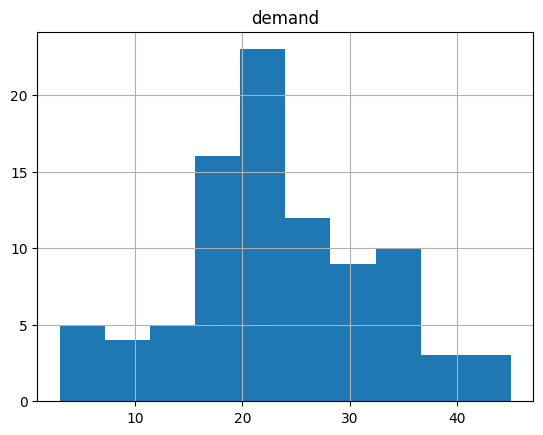

In [24]:
df_test.hist("demand")

In [25]:
df_test.to_csv("test.csv", index=False)